In [1]:
# Refactored Code with Functions for Modularity and Flexibility

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from pandas.plotting import autocorrelation_plot

from commons import create_sequences, load_data, add_advanced_time_features, add_lag_features, filter_and_save_data, scale_data, scale_selected_columns, preprocess_data_without_scaling, preprocess_data_with_scaling, plot_anomalies
from commons import timesteps, data_file_path, time_column, target_column, train_data_split, train_data_path, eval_data_path, anomaly_trashold   # Variables which are shared across the application

In [2]:
# Model specific code 
def tune_isolation_forest(train_data, feature_columns, param_grid, scoring='f1', cv=3):
    """
    Performs hyperparameter tuning for an Isolation Forest model using GridSearchCV.

    Parameters:
    train_data (pd.DataFrame): Training data to fit the model.
    feature_columns (list): List of feature columns used for model training.
    param_grid (dict): Grid of parameters to search over.
    scoring (str): The scoring metric to optimize. Default is 'f1'.
    cv (int): Number of cross-validation folds. Default is 3.

    Returns:
    dict: The best parameters found during tuning.
    """
    # Initialize the IsolationForest model
    iso_forest = IsolationForest(random_state=42)
    
    # Initialize GridSearchCV with the given parameter grid
    grid_search = GridSearchCV(
        estimator=iso_forest, 
        param_grid=param_grid, 
        scoring=scoring, 
        cv=cv, 
        n_jobs=1
    )
    
    # Fit the model to the training data
    grid_search.fit(train_data[feature_columns])
    
    # Print the best parameters
    print("Best parameters found: ", grid_search.best_params_)
    
    # Return the best parameters
    #return grid_search.best_params_
    #return grid_search for furher processing
    return grid_search

In [3]:
train_data_preprocessed =preprocess_data_without_scaling(
    train_data_path, 
    time_column, 
    target_column, 
    timesteps, 
    drop_time_column=False
)


NaN counts before preprocessing:
timestamp    0
value        0
dtype: int64
NaN counts after adding time features:
timestamp       0
value           0
hour            0
day             0
day_of_week     0
week_of_year    0
month           0
is_weekend      0
hour_sin        0
hour_cos        0
dtype: int64


In [4]:
nan_counts = train_data_preprocessed.isna().sum()
print(nan_counts)

timestamp          0
value              0
hour               0
day                0
day_of_week        0
week_of_year       0
month              0
is_weekend         0
hour_sin           0
hour_cos           0
lag_1              0
lag_2              0
lag_3              0
lag_4              0
lag_5              0
lag_6              0
lag_7              0
lag_8              0
lag_9              0
lag_10             0
lag_11             0
lag_12             0
lag_13             0
lag_14             0
lag_15             0
moving_mean_288    0
moving_std_288     0
dtype: int64


In [5]:
scaler = StandardScaler()

# Apply scaling to the data
scaled_data_for_training, scaled_feature_names = scale_data(
    scaler=scaler, 
    data=train_data_preprocessed, 
    target_column = target_column, 
    n_lags=timesteps  # Dynamic number of lags
)

print("Scaled feature names:", scaled_feature_names)


Scaled feature names: ['value', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'moving_mean_288', 'moving_std_288']


In [6]:
# Example usage of the function
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': ['auto', 0.8],
    'contamination': [0.01, 0.02, 0.05],
    'max_features': [1.0, 0.8]
}


# Define feature columns by excluding specific non-feature columns
feature_columns = scaled_data_for_training.columns.difference([time_column, 'anomaly']).tolist()

# Now you can use feature_columns dynamically
print(feature_columns)

['day', 'day_of_week', 'hour', 'hour_cos', 'hour_sin', 'is_weekend', 'lag_1', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'month', 'moving_mean_288', 'moving_std_288', 'value', 'week_of_year']


In [7]:
#train with data which are not the last 100 days since we know that we want to use this to validate our model
grid_search = tune_isolation_forest(scaled_data_for_training, feature_columns, param_grid=param_grid)

Best parameters found:  {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100}


In [8]:
# Drop the 'Time' column before fitting the model, as IsolationForest only accepts numeric features
train_data_filtered_numeric = scaled_data_for_training.drop(columns=[time_column])

print(train_data_filtered_numeric.dtypes)

value              float64
hour                 int32
day                  int32
day_of_week          int32
week_of_year        UInt32
month                int32
is_weekend           int64
hour_sin           float64
hour_cos           float64
lag_1              float64
lag_2              float64
lag_3              float64
lag_4              float64
lag_5              float64
lag_6              float64
lag_7              float64
lag_8              float64
lag_9              float64
lag_10             float64
lag_11             float64
lag_12             float64
lag_13             float64
lag_14             float64
lag_15             float64
moving_mean_288    float64
moving_std_288     float64
dtype: object


In [9]:
# Retrain Isolation Forest with best parameters
best_iso_forest = grid_search.best_estimator_

# Fit the model with the numeric dataset (without the 'Time' column)
best_iso_forest.fit(train_data_filtered_numeric)

IsolationForest(contamination=0.01, random_state=42)

In [10]:
last_x_days_data = preprocess_data_with_scaling(
    eval_data_path, 
    time_column, 
    target_column, 
    timesteps,
    scaler,
    drop_time_column=False
)
# Drop the 'Time' column before fitting the model, as IsolationForest only accepts numeric features
last_x_days_data_numeric = last_x_days_data.drop(columns=[time_column])
print(last_x_days_data_numeric.head())

NaN counts before preprocessing:
timestamp    0
value        0
dtype: int64
NaN counts after adding time features:
timestamp       0
value           0
hour            0
day             0
day_of_week     0
week_of_year    0
month           0
is_weekend      0
hour_sin        0
hour_cos        0
dtype: int64
       value  hour  day  day_of_week  week_of_year  month  is_weekend  \
15 -0.856676    22    2            0            49     12           0   
16 -0.756508    22    2            0            49     12           0   
17 -0.761810    22    2            0            49     12           0   
18 -0.728146    22    2            0            49     12           0   
19 -0.888284    22    2            0            49     12           0   

    hour_sin  hour_cos     lag_1  ...     lag_8     lag_9    lag_10    lag_11  \
15      -0.5  0.866025 -0.867372  ... -0.878055 -0.878316 -1.043680 -0.977891   
16      -0.5  0.866025 -0.856611  ... -0.869505 -0.877993 -0.878247 -1.043605   
17      -0

In [11]:
# Extract the feature names that were used during model training
trained_feature_names = best_iso_forest.feature_names_in_

# Reorder the columns in last_x_days_data to match the feature names used during training
last_x_days_data_reordered = last_x_days_data[trained_feature_names]

# Perform prediction using the Isolation Forest model
last_x_days_data['anomaly'] = best_iso_forest.predict(last_x_days_data_reordered)

# Convert the anomaly predictions (-1 for anomaly, 1 for normal) to (1 for anomaly, 0 for normal)
last_x_days_data['anomaly'] = np.where(last_x_days_data['anomaly'] == -1, 1, 0)

# Display the results
last_x_days_data.head()


,timestamp,value,hour,day,day_of_week,week_of_year,month,is_weekend,hour_sin,hour_cos,...,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,moving_mean_288,moving_std_288,anomaly
15,2013-12-02 22:30:00,-0.856676,22,2,0,49,12,0,-0.5,0.866025,...,-0.878316,-1.043680,-0.977891,-1.103985,-1.317861,-1.443862,-1.546545,-1.125353,-1.427530,0
16,2013-12-02 22:35:00,-0.756508,22,2,0,49,12,0,-0.5,0.866025,...,-0.877993,-0.878247,-1.043605,-0.977829,-1.103922,-1.317794,-1.443788,-1.059068,-1.294191,0
17,2013-12-02 22:40:00,-0.761810,22,2,0,49,12,0,-0.5,0.866025,...,-0.869442,-0.877924,-0.878172,-1.043544,-0.977765,-1.103853,-1.317720,-1.039312,-1.305008,0
18,2013-12-02 22:45:00,-0.728146,22,2,0,49,12,0,-0.5,0.866025,...,-0.961410,-0.869374,-0.877849,-0.878109,-1.043480,-0.977695,-1.103779,-1.018296,-1.298609,0
19,2013-12-02 22:50:00,-0.888284,22,2,0,49,12,0,-0.5,0.866025,...,-0.823840,-0.961343,-0.869298,-0.877786,-0.878045,-1.043410,-0.977622,-1.048074,-1.261249,0


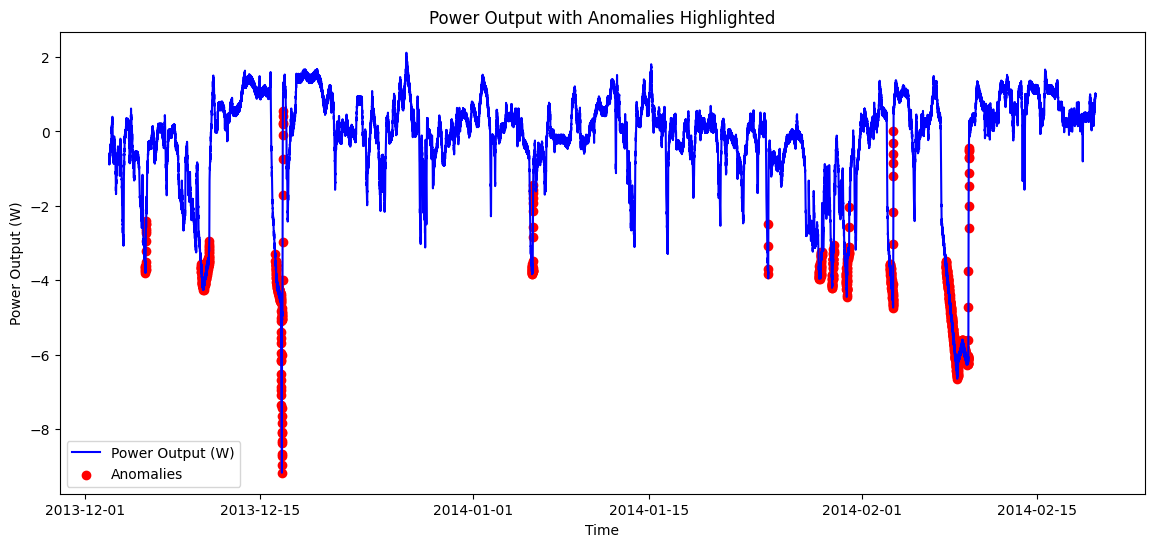

In [12]:


# Visualize anomalies in the power output
plot_anomalies(last_x_days_data, time_column=time_column, value_column=target_column, anomaly_column='anomaly')


In [13]:
# Saving the trained IsolationForest model using joblib

# Define the path for saving the model
model_save_path = f'USModels/isolation_forest_model_{timesteps}.pkl'
scaler_save_path = f'USModels/scaler_iso_forest_{timesteps}.pkl'

# Save the model using joblib
joblib.dump(best_iso_forest, model_save_path)
# Save the scaler
joblib.dump(scaler, scaler_save_path)

model_save_path


'USModels/isolation_forest_model_15.pkl'